In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [5]:
np.random.seed(0)

In [6]:
# Data Preparation

In [7]:
def load_data(file_path):
    tokenizer = Tokenizer(filters="")
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

In [8]:
X_train, tokenizer_en = load_data('/root/userspace/private/RNN/train.en')
Y_train, tokenizer_ja = load_data('/root/userspace/private/RNN/train.ja')

In [9]:
en_vocab_size = len(tokenizer_en.word_index) + 1
jp_vocab_size = len(tokenizer_ja.word_index) + 1

In [10]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train,
                                                                Y_train,
                                                                test_size=0.02,
                                                                random_state=42)

In [11]:
X_train = pad_sequences(X_train, padding='post')
Y_train = pad_sequences(Y_train, padding='post')

In [12]:
dim_seq_input = len(X_train[0])
dim_seq_output = len(Y_train[0])

In [13]:
# Building a model

In [14]:
class RNNEncoderDecoder(object):
    def __init__(self, dim_seq_input, dim_input, dim_seq_output, dim_output, dim_emb, dim_hid, dim_vocab_input, dim_vocab_output):
        self._model = None
        self._model_validation_encoder = None
        self._model_validation_decoder = None
        
        self.dim_seq_input = dim_seq_input
        self.dim_input = dim_input
        
        self.dim_seq_output = dim_seq_output
        self.dim_output = dim_output
        
        self.dim_emb = dim_emb
        self.dim_hid = dim_hid
        
        self.dim_vocab_input = dim_vocab_input
        self.dim_vocab_output = dim_vocab_output
        
        self._encoder_inputs = None
        self._encoder_states = None
        
        self._decoder_embedding = None
        self._decoder_lstm = None
        self._decoder_dense = None
        
    def inference(self):
        from keras.models import Model
        from keras.layers import Input, Embedding, Dense, LSTM

        # Encoder
        ## Input Layer
        self._encoder_inputs = Input(shape=(self.dim_seq_input,))

        ## Embedding Layer
        encoder_embedded = Embedding(self.dim_vocab_input, self.dim_emb, mask_zero=True)(self._encoder_inputs) # (dim_seq_input,)->(dim_seq_input, dim_emb)
        
        ## LSTM Layer
        _, *(self._encoder_states) = LSTM(self.dim_hid, return_state=True)(encoder_embedded)  # (dim_seq_input, dim_emb)->(dim_seq_input, dim_hid)

        # Decoder
        ## Instance
        self._decoder_embedding = Embedding(self.dim_vocab_output, self.dim_emb)
        self._decoder_lstm = LSTM(self.dim_hid, return_sequences=True, return_state=True)
        self._decoder_dense = Dense(self.dim_vocab_output, activation='softmax')
        
        ## Input Layer
        decoder_inputs = Input(shape=(self.dim_seq_output,))

        ## Embedding Layer
        decoder_embedded = self._decoder_embedding(decoder_inputs)  # (dim_seq_output,)->(dim_seq_output, dim_emb)
        
        ## LSTM Layer       
        decoder_outputs, _, _ = self._decoder_lstm(decoder_embedded, initial_state=self._encoder_states) # (dim_seq_output, dim_emb)->(dim_seq_output, dim_hid)
        
        ## Output Layer
        predictions = self._decoder_dense(decoder_outputs) # shape: (dim_seq_output, dim_hid)->(dim_seq_output, dim_vocab_output)
        
        return Model([self._encoder_inputs, decoder_inputs], predictions)       
 
    def inference_validation(self):
        from keras.models import Model
        from keras.layers import Input        

        # Encoder
        model_encoder = Model(self._encoder_inputs, self._encoder_states)

        # Decoder
        ## Input Layer
        decoder_inputs = Input(shape=(1,))

        ## Embedding Layer
        decoder_embedded = self._decoder_embedding(decoder_inputs) 

        ## LSTM Layer
        decoder_states_inputs = [Input(shape=(self.dim_hid,)), Input(shape=(self.dim_hid,))]
        decoder_outputs, *decoder_states = self._decoder_lstm(decoder_embedded, initial_state=decoder_states_inputs)

        ## Output Layer
        predictions = self._decoder_dense(decoder_outputs)

        model_decoder = Model([decoder_inputs] + decoder_states_inputs, [predictions] + decoder_states)

        return model_encoder, model_decoder
               
    def predict(self, X, bos_eos, max_output_length = 1000):
        states_value = self._model_validation_encoder.predict(X)

        target_seq = np.array(bos_eos[0])
        output_seq= bos_eos[0][:]

        while True:
            output_tokens, *states_value = self._model_validation_decoder.predict([target_seq] + states_value)
            sampled_token_index = [np.argmax(output_tokens[0, -1, :])]
            output_seq += sampled_token_index

            if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
                break

            target_seq = np.array(sampled_token_index)

        return output_seq

    def compile(self):
        self._model = self.inference()
        self._model.compile(loss='sparse_categorical_crossentropy',
                            optimizer='rmsprop',
                            metrics=['accuracy'])
        
        self._model_validation_encoder, self._model_validation_decoder = self.inference_validation()
        
    def fit(self, X_train, Y_train, epochs, batch_size, verbose=1):
        train_target = np.hstack((Y_train[:, 1:], np.zeros((len(Y_train),1), dtype=np.int32)))
        
        history = self._model.fit([X_train, Y_train],
                                  np.expand_dims(train_target, -1),
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=verbose,
                                  validation_split=0.2)
        
        return history.history
    
    def show_graph(self):
        return model_to_dot(self._model).create(prog='dot', format='svg')

In [15]:
model = RNNEncoderDecoder(dim_seq_input=dim_seq_input,
                          dim_input=None,
                          dim_seq_output=dim_seq_output,
                          dim_output=None,
                          dim_emb=256,
                          dim_hid=256,
                          dim_vocab_input=en_vocab_size,
                          dim_vocab_output=jp_vocab_size)

In [16]:
model.compile()

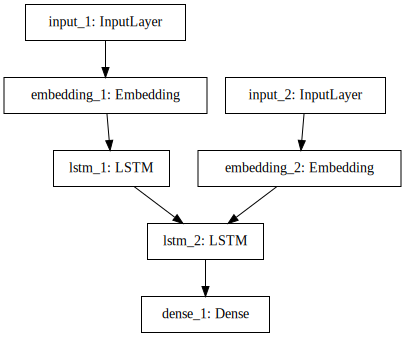

In [17]:
SVG(model.show_graph())

In [18]:
# Training the model

In [19]:
history = model.fit(X_train,
                    Y_train,
                    epochs=15,
                    batch_size=128)

Train on 39200 samples, validate on 9800 samples
Epoch 1/15
39200/39200 [==============================] - 107s 3ms/step - loss: 2.9554 - acc: 0.4774 - val_loss: 2.3073 - val_acc: 0.5784
Epoch 2/15
39200/39200 [==============================] - 104s 3ms/step - loss: 2.0823 - acc: 0.6179 - val_loss: 1.9541 - val_acc: 0.6415
Epoch 3/15
39200/39200 [==============================] - 103s 3ms/step - loss: 1.8104 - acc: 0.6613 - val_loss: 1.7654 - val_acc: 0.6697
Epoch 4/15
39200/39200 [==============================] - 103s 3ms/step - loss: 1.6444 - acc: 0.6860 - val_loss: 1.6529 - val_acc: 0.6889
Epoch 5/15
39200/39200 [==============================] - 103s 3ms/step - loss: 1.5161 - acc: 0.7050 - val_loss: 1.5522 - val_acc: 0.7021
Epoch 6/15
39200/39200 [==============================] - 103s 3ms/step - loss: 1.4082 - acc: 0.7219 - val_loss: 1.4832 - val_acc: 0.7131
Epoch 7/15
39200/39200 [==============================] - 103s 3ms/step - loss: 1.3141 - acc: 0.7376 - val_loss: 1.4181 - v

In [26]:
model._model.save('/root/userspace/private/RNN/_model.h5')

/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [24]:
model._model_validation_encoder.save('/root/userspace/private/RNN/_model_validation_encoder.h5')

In [25]:
model._model_validation_decoder.save('/root/userspace/private/RNN/_model_validation_decoder.h5')

/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_4:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'input_5:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [130]:
# Confirming the result

In [27]:
def show_graph(history, key, title=None, xlabel=None, ylabel=None, yscale=None):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    ax.plot(history[key])

    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    if yscale:
        plt.yscale(yscale)

    plt.show()

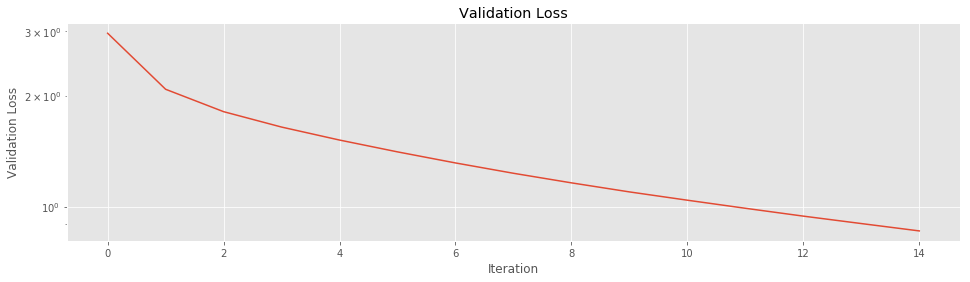

In [28]:
show_graph(history, 'loss', 'Validation Loss', 'Iteration', 'Validation Loss', 'log')

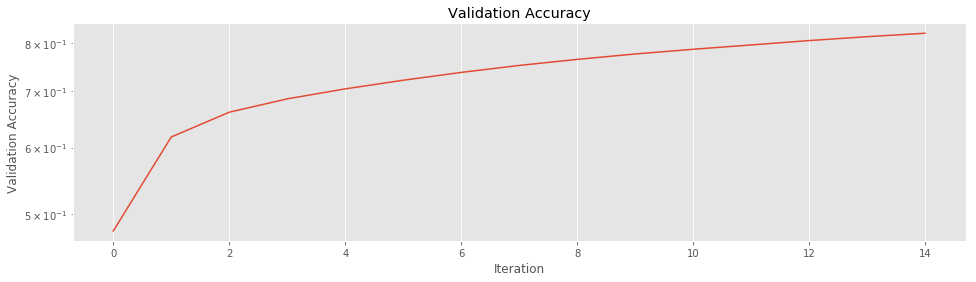

In [29]:
show_graph(history, 'acc', 'Validation Accuracy', 'Iteration', 'Validation Accuracy', 'log')

In [30]:
detokenizer_en = dict(map(reversed, tokenizer_en.word_index.items()))
detokenizer_ja = dict(map(reversed, tokenizer_ja.word_index.items()))

In [31]:
bos_eos = tokenizer_ja.texts_to_sequences(["<s>", "</s>"])

In [32]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu(refs, preds):
    return np.mean([sentence_bleu(r, p, emulate_multibleu=True) for r, p in zip(refs, preds)])

In [41]:
for text_no in range(len(X_validation)):
    inp = [detokenizer_en[i] for i in X_validation[text_no][1:-1]]
    ref = [detokenizer_ja[i] for i in Y_validation[text_no][1:-1]]
    
    input_seq = pad_sequences([X_validation[text_no]], dim_seq_input, padding='post')
    pred = [detokenizer_ja[i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.0:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['you', 'may', 'extend', 'your', 'stay', 'in', 'tokyo', '.']
正解文: ['東京', '滞在', 'を', '延ば', 'し', 'て', 'も', 'い', 'い', 'で', 'す', 'よ', '。']
生成文: ['東京', 'に', 'は', '東京', 'へ', '行', 'っ', 'て', 'も', 'い', 'い', 'で', 'す', 'よ', '。']
bleu: 0.8265168183793802

text_no: 1
元の文: ['i', 'study', 'at', 'school', '.']
正解文: ['私', 'は', '学校', 'で', '勉強', 'する', '。']
生成文: ['私', 'は', '学校', 'で', '学校', 'を', '通', 'っ', 'て', 'い', 'る', '。']
bleu: 0.8034284189446518

text_no: 2
元の文: ['i', 'always', 'brush', 'my', 'coat', 'when', 'i', 'come', 'home', '.']
正解文: ['私', 'は', '帰宅', 'する', 'と', 'いつ', 'も', 'コート', 'に', 'ブラシ', 'を', 'かけ', 'る', '。']
生成文: ['私', 'は', 'いつ', 'も', '家', 'に', 'い', 'る', 'とき', 'に', 'タクシー', 'を', '使', 'う', '。']
bleu: 0.8545740127924681

text_no: 3
元の文: ['your', 'mother', 'has', 'made', 'you', 'what', 'you', 'are', '.']
正解文: ['君', 'が', '今日', 'あ', 'る', 'の', 'は', 'お', '母', 'さん', 'の', 'おかげ', 'だ', '。']
生成文: ['あなた', 'の', 'お', '母', 'さん', 'が', '君', 'の', '考え', 'を', 'し', 'た', 'もの', 'だ', '。']
bleu: 0.8265168

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 201
元の文: ['i', 'don', "'t", 'have', 'much', 'money', '.']
正解文: ['私', 'は', 'たい', 'し', 'て', 'お', '金', 'を', '持', 'っ', 'て', 'い', 'ま', 'せ', 'ん', '。']
生成文: ['金', 'は', 'あまり', 'な', 'く', 'て', 'は', 'な', 'い', '。']
bleu: 0.8408964152537145

text_no: 202
元の文: ['i', 'never', 'see', 'this', 'picture', 'without', 'thinking', 'of', 'him', '.']
正解文: ['この', '写真', 'を', '見', 'る', 'と', 'いつ', 'も', '彼', 'を', '思い出', 'す', '。']
生成文: ['この', '絵', 'を', '見', 'る', 'と', '彼', 'を', '思い出', 'す', '。']
bleu: 0.8931539818068694

text_no: 203
元の文: ['he', 'is', 'anxious', 'for', 'her', 'to', 'come', '.']
正解文: ['彼', 'は', '彼女', 'が', '来る', '事', 'を', '切望', 'し', 'て', 'い', 'る', '。']
生成文: ['彼', 'は', '彼女', 'が', '来る', 'の', 'を', '楽しみ', 'だ', 'と', '思', 'っ', 'て', 'い', 'る', '。']
bleu: 0.8408964152537145

text_no: 204
元の文: ['i', 'can', 'show', 'you', 'a', 'better', 'time', '.']
正解文: ['僕', 'は', 'もっと', 'い', 'い', '目', 'を', 'みせ', 'る', 'こと', 'が', 'でき', 'る', '。']
生成文: ['もっと', '時間', 'を', '貸', 'し', 'て', 'あげ', 'よ', 'う', '。']
bleu: 0.66874030

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 341
元の文: ['will', 'it', 'rain', 'tomorrow', '?']
正解文: ['明日', 'は', '雨', 'が', '降', 'る', 'で', 'しょ', 'う', 'か', '。']
生成文: ['明日', 'は', '雨', 'が', '降', 'る', 'で', 'しょ', 'う', 'か', '。']
bleu: 0.9510699415570292

text_no: 342
元の文: ['his', 'music', 'is', 'too', 'noisy', '.']
正解文: ['彼', 'の', '音楽', 'は', 'やかまし', 'すぎ', 'る', 'よ', '。']
生成文: ['彼', 'の', '音楽', 'は', 'あまり', '興味', 'が', 'あ', 'り', 'ま', 'せ', 'ん', '。']
bleu: 0.7875110621102679

text_no: 343
元の文: ['don', "'t", 'get', 'off', 'the', 'bus', 'till', 'it', 'stops', '.']
正解文: ['バス', 'が', '止ま', 'る', 'まで', '降り', 'る', 'な', '。']
生成文: ['バス', 'を', '降り', 'て', '、', '駅', 'まで', '降り', 'て', 'は', 'いけ', 'ま', 'せ', 'ん', '。']
bleu: 0.6042750794713536

text_no: 344
元の文: ['they', 'spoke', 'well', 'of', 'their', 'grandson', '.']
正解文: ['彼', 'ら', 'は', '自分', 'の', '息子', 'の', '事', 'を', 'よく', '言', 'う', '。']
生成文: ['彼', 'ら', 'は', '彼', 'の', '援助', 'を', 'し', 'て', 'い', 'る', '。']
bleu: 0.8408964152537145

text_no: 345
元の文: ['ten', 'years', 'have', 'passed', 'since', 'he', 'went

In [38]:
for text_no in range(len(X_validation)):
    inp = [detokenizer_en[i] for i in X_validation[text_no][1:-1]]
    ref = [detokenizer_ja[i] for i in Y_validation[text_no][1:-1]]
    
    input_seq = pad_sequences([X_validation[text_no]], dim_seq_input, padding='post')
    pred = [detokenizer_ja[i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.95:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 20
元の文: ['he', 'is', 'almost', 'always', 'at', 'home', '.']
正解文: ['彼', 'は', 'ほとんど', 'いつ', 'も', '家', 'に', 'い', 'る', '。']
生成文: ['彼', 'は', 'いつ', 'も', '家', 'に', 'い', 'る', '。']
bleu: 0.9709835434146469

text_no: 64
元の文: ['she', 'is', 'not', 'as', 'tall', 'as', 'he', '.']
正解文: ['彼女', 'は', '彼', 'ほど', '背', 'が', '高', 'く', 'な', 'い', '。']
生成文: ['彼女', 'は', '彼', 'ほど', '背', 'が', '高', 'く', 'な', 'い', '。']
bleu: 0.9510699415570292

text_no: 111
元の文: ['it', 'is', 'impossible', 'for', 'him', 'to', 'become', 'a', 'doctor', '.']
正解文: ['彼', 'が', '医者', 'に', 'な', 'る', 'の', 'は', '不', '可能', 'だ', '。']
生成文: ['彼', 'が', '医者', 'に', 'な', 'る', 'の', 'は', '不', '可能', 'だ', '。']
bleu: 0.9554427922043668

text_no: 127
元の文: ['i', "'d", 'like', 'you', 'to', 'cut', 'my', 'hair', '.']
正解文: ['髪', 'を', '切', 'っ', 'て', 'もら', 'い', 'た', 'い', 'ん', 'で', 'す', 'が', '。']
生成文: ['髪', 'を', '切', 'っ', 'て', 'ほし', 'い', 'の', 'で', 'す', 'が', '。']
bleu: 0.9554427922043668



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 206
元の文: ['how', 'fast', 'he', 'can', 'run', '!']
正解文: ['彼', 'は', 'なん', 'と', '速', 'く', '走れ', 'る', 'の', 'で', 'しょ', 'う', '。']
生成文: ['彼', 'は', 'なん', 'と', '速', 'く', '走', 'る', 'の', 'で', 'しょ', 'う', '。']
bleu: 0.9590965597935381

text_no: 255
元の文: ['i', 'said', 'it', 'might', 'rain', '.']
正解文: ['雨', 'が', '降', 'る', 'か', 'も', 'しれ', 'な', 'い', 'と', '私', 'は', '言', 'っ', 'た', '。']
生成文: ['雨', 'が', '降', 'る', 'と', '言', 'っ', 'て', 'い', 'た', '。']
bleu: 0.9764540896763105

text_no: 267
元の文: ['this', 'is', 'the', 'end', 'of', 'my', 'story', '.']
正解文: ['これ', 'で', '私', 'の', '話', 'は', '終わり', 'で', 'す', '。']
生成文: ['これ', 'は', '私', 'の', '話', 'で', 'す', '。']
bleu: 0.9671682101338347

text_no: 276
元の文: ['may', 'i', 'borrow', 'your', 'car', '?']
正解文: ['自動', '車', 'を', '借り', 'て', 'も', 'い', 'い', 'で', 'す', 'か', '。']
生成文: ['車', 'を', '借り', 'て', 'も', 'い', 'い', 'で', 'す', 'か', '。']
bleu: 0.9510699415570292



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 341
元の文: ['will', 'it', 'rain', 'tomorrow', '?']
正解文: ['明日', 'は', '雨', 'が', '降', 'る', 'で', 'しょ', 'う', 'か', '。']
生成文: ['明日', 'は', '雨', 'が', '降', 'る', 'で', 'しょ', 'う', 'か', '。']
bleu: 0.9510699415570292

text_no: 377
元の文: ['he', 'hit', 'me', 'on', 'the', 'head', '.']
正解文: ['彼', 'は', '僕', 'の', '頭', 'を', '殴', 'っ', 'た', '。']
生成文: ['彼', 'は', '私', 'の', '頭', 'を', '殴', 'っ', 'た', '。']
bleu: 0.9740037464252967

text_no: 400
元の文: ['i', 'like', 'dogs', '.']
正解文: ['私', 'は', '、', '犬', 'が', '好き', 'で', 'す', '。']
生成文: ['私', 'は', '犬', 'が', '好き', 'で', 'す', '。']
bleu: 0.9671682101338347

text_no: 419
元の文: ['we', 'made', 'him', 'go', '.']
正解文: ['私', 'たち', 'は', '彼', 'を', '行', 'か', 'せ', 'た', '。']
生成文: ['私', 'たち', 'は', '彼', 'を', '行', 'か', 'せ', 'た', '。']
bleu: 0.9740037464252967

text_no: 471
元の文: ['it', 'is', 'no', 'use', 'your', 'pretending', 'that', 'you', 'know', 'nothing', '.']
正解文: ['何', 'も', '知', 'ら', 'な', 'い', 'ふり', 'を', 'し', 'て', 'も', '無駄', 'だ', '。']
生成文: ['君', 'が', '何', 'を', 'し', 'て', 'も', '知'